In [ ]:
"""
A. Tham khảo hưỡng dẫn về GNN tại:
+ https://viblo.asia/p/gioi-thieu-ve-graph-neural-networks-gnns-yZjJYG7MVOE
+ https://docs.dgl.ai/en/0.8.x/tutorials/blitz/4_link_predict.html
+ https://arxiv.org/ftp/arxiv/papers/1812/1812.08434.pdf


B. Yêu cầu:
1. Tìm hiểu và trình bày tổng quan về GNN
2. Sử dụng GCN để dự đoán liên kết mạng xã hội mầ bạn lựa chọn
+ https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html
3. Đánh giá kết quả giữa GCN và các phương pháp trong LAB 04.01 / 04.02
"""

1. Tổng Quan về GNN

GNN là mô hình học sâu được thiết kế đặc biệt cho dữ liệu đồ thị. Các đặc điểm chính bao gồm:

Dữ liệu đồ thị: Bao gồm các nút (nodes/vertices) và cạnh (edges), có thể là đồ thị vô hướng hoặc có hướng.
Truyền bá thông tin: GNN sử dụng kỹ thuật message passing để lan truyền thông tin giữa các nút và cập nhật đặc trưng của nút.
Lớp học sâu đồ thị:
GCN (Graph Convolutional Network): Mạng tích chập đồ thị.
GraphSAGE, GAT (Graph Attention Networks), và các biến thể khác.
Ứng dụng GNN:

Dự đoán liên kết (Link Prediction).
Phân loại nút và đồ thị (Node/Graph Classification).
Phân tích mạng xã hội, sinh học, và hơn thế nữa.
2. Sử Dụng GCN để Dự Đoán Liên Kết Mạng Xã Hội
Công cụ và thư viện:
StellarGraph: Thư viện hỗ trợ các mô hình GNN như GCN.
Dữ liệu mạng xã hội: Chọn một bộ dữ liệu như Cora, PubMed, hoặc tự xây dựng từ nguồn mạng xã hội (Facebook, Twitter, etc.).

In [ ]:
!pip install dgl
!pip install torchdata==0.6.1

In [42]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import Model, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping


class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        """
        GCN với 2 lớp GraphConv.

        Parameters:
            in_feats (int): Số đặc trưng đầu vào.
            hidden_feats (int): Số đặc trưng của lớp ẩn.
            out_feats (int): Số đặc trưng đầu ra.
        """
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, out_feats)

    def forward(self, g, features):
        """
        Truyền dữ liệu qua các lớp GCN.

        Parameters:
            g (DGLGraph): Đồ thị DGL.
            features (Tensor): Đặc trưng của các node.

        Returns:
            Tensor: Đặc trưng của node sau khi lan truyền qua GCN.
        """
        x = F.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x


class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với dataset đã cho.

        Parameters:
            dataset (str): Tên dataset ('karate', 'les', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        else:
            raise ValueError("Dataset không hợp lệ")
        self.results_df = pd.DataFrame()
    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_ml(self):
        """Huấn luyện mô hình ML và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Lưu y_test và y_pred_proba cho ROC
        self.y_test = y_test
        self.rf_y_pred_proba = y_pred_proba

        # Tính các metric
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Tạo DataFrame mới cho Random Forest
        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        # Concatenate với kết quả cũ
        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)

        # Hiển thị bảng kết quả
        print("\nBảng kết quả mở rộng với Random Forest:")
        print(self.results_df)


    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống và vẽ ROC Curve cho tất cả các phương pháp."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(self.train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(self.train_G, [(u, v)]))[0][2],
        }

        results = []

        plt.figure(figsize=(10, 6))  # Tạo biểu đồ ROC chung

        # Tính kết quả cho các phương pháp truyền thống và vẽ ROC
        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)

            # Tính các metric
            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, [1 if s > 0 else 0 for s in y_scores])
            precision = precision_score(y_true, [1 if s > 0 else 0 for s in y_scores])
            recall = recall_score(y_true, [1 if s > 0 else 0 for s in y_scores])
            f1 = f1_score(y_true, [1 if s > 0 else 0 for s in y_scores])

            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

            # Vẽ ROC Curve cho phương pháp truyền thống
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

        # Thêm đường ROC cho Random Forest
        rf_auc = self.results_df.loc[self.results_df["Method"] == "Random Forest", "AUC"].values[0]
        rf_fpr, rf_tpr, _ = roc_curve(self.y_test, self.rf_y_pred_proba)
        plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.3f})")

        # Thêm đường ROC cho GCN
        gcn_auc = self.results_df.loc[self.results_df["Method"] == "GCN", "AUC"].values[0]
        gcn_fpr, gcn_tpr, _ = roc_curve(self.gcn_labels, self.gcn_preds)
        plt.plot(gcn_fpr, gcn_tpr, label=f'GCN (AUC = {gcn_auc:.3f})')

        # Cập nhật kết quả vào DataFrame
        self.results_df = pd.DataFrame(results + self.results_df.to_dict('records'))

        print("\nBảng so sánh kết quả cho các phương pháp:")
        print(self.results_df)

        # Vẽ biểu đồ ROC chung
        plt.plot([0, 1], [0, 1], 'k--')  # Đường chuẩn đoán ngẫu nhiên
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves cho các phương pháp truyền thống và học máy')
        plt.legend()
        plt.show()


    def gcn_link_prediction(self):
        """Huấn luyện và đánh giá mô hình GCN."""
        print("\n=== Dự đoán liên kết bằng GCN ===")

        # Chuyển NetworkX sang DGL và thêm self-loops
        dgl_graph = dgl.from_networkx(self.train_G)
        dgl_graph = dgl.add_self_loop(dgl_graph)

        # Create a mapping from node to index
        node_to_index = {node: i for i, node in enumerate(self.train_G.nodes())}

        # Map edges to integer indices
        positive_edges = [(node_to_index[u], node_to_index[v]) for u, v in self.test_edges]
        negative_edges = [(node_to_index[u], node_to_index[v]) for u, v in self.test_non_edges]

        features = torch.eye(self.train_G.number_of_nodes())  # Ma trận đặc trưng (đơn vị)

        edge_list = positive_edges + negative_edges
        labels = torch.tensor([1] * len(positive_edges) + [0] * len(negative_edges), dtype=torch.float32)

        # Định nghĩa mô hình GCN
        model = GCN(in_feats=features.shape[1], hidden_feats=16, out_feats=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # Huấn luyện mô hình
        for epoch in range(100):
            model.train()
            logits = model(dgl_graph, features)
            preds = torch.sigmoid(logits)
            edge_preds = preds[[u for u, v in edge_list], 0]

            loss = F.binary_cross_entropy(edge_preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Dự đoán liên kết
        with torch.no_grad():
            model.eval()
            logits = model(dgl_graph, features)
            preds = torch.sigmoid(logits)
            edge_preds = preds[[u for u, v in edge_list], 0]

        # Lưu labels và predictions cho ROC
        self.gcn_labels = labels.numpy()
        self.gcn_preds = edge_preds.numpy()

        # Đánh giá AUC
        auc = roc_auc_score(self.gcn_labels, self.gcn_preds)
        print(f"AUC GCN: {auc:.3f}")

        # Thêm kết quả vào DataFrame
        gcn_results = pd.DataFrame([{
            "Method": "GCN",
            "AUC": auc,
            "Accuracy": accuracy_score(self.gcn_labels, (self.gcn_preds > 0.5).astype(int)),
            "Precision": precision_score(self.gcn_labels, (self.gcn_preds > 0.5).astype(int)),
            "Recall": recall_score(self.gcn_labels, (self.gcn_preds > 0.5).astype(int)),
            "F1-score": f1_score(self.gcn_labels, (self.gcn_preds > 0.5).astype(int))
        }])
        self.results_df = pd.concat([self.results_df, gcn_results], ignore_index=True)



    def run_experiment(self):
        """Chạy thử nghiệm hoàn chỉnh."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_ml()  # Huấn luyện Random Forest và lưu kết quả
        self.gcn_link_prediction()  # Huấn luyện GCN và lưu kết quả
        self.evaluate_baselines()  # Cuối cùng gọi evaluate_baselines

Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
3. Florentine Families Network
Nhập lựa chọn (1-3): 2

=== Phân tích mạng ===
Số node: 77
Số cạnh: 254
Clustering trung bình: 0.573


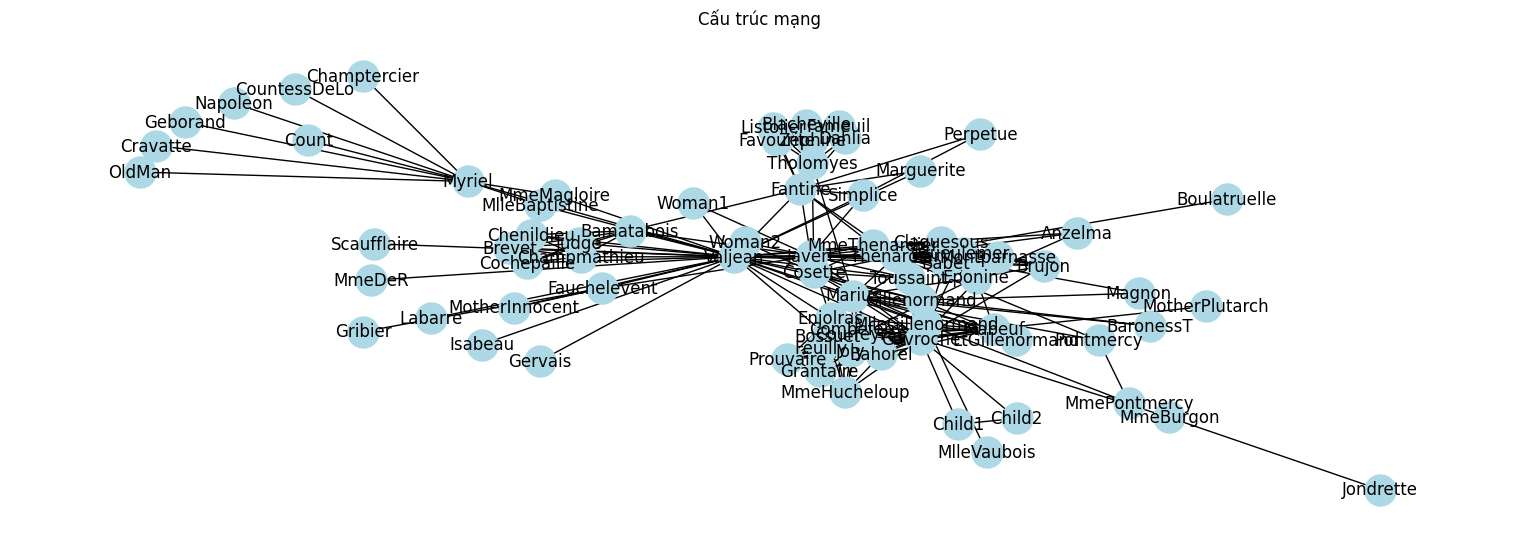

Train edges: 204
Test positive edges: 50
Test negative edges: 50

Bảng kết quả mở rộng với Random Forest:
          Method       AUC  Accuracy  Precision    Recall  F1-score
0  Random Forest  0.891403       0.9   0.888889  0.941176  0.914286

=== Dự đoán liên kết bằng GCN ===
AUC GCN: 0.891

Bảng so sánh kết quả cho các phương pháp:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.900600      0.79   0.723077  0.940000  0.817391
1      Jaccard Coefficient  0.891600      0.79   0.723077  0.940000  0.817391
2              Adamic-Adar  0.910600      0.79   0.723077  0.940000  0.817391
3  Preferential Attachment  0.755200      0.53   0.516484  0.940000  0.666667
4            Random Forest  0.891403      0.90   0.888889  0.941176  0.914286
5                      GCN  0.891400      0.79   0.784314  0.800000  0.792079


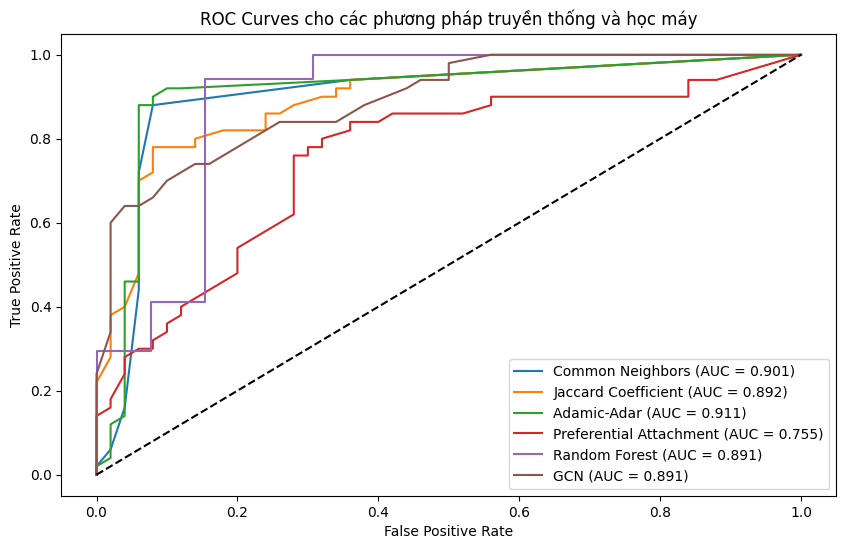

In [43]:
if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")
    print("3. Florentine Families Network")
    choice = input("Nhập lựa chọn (1-3): ")
    datasets = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if choice in datasets:
        lp = LinkPrediction(dataset=datasets[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")

**So sánh các phương pháp:**
---
---

1.   Phương pháp truyền thống (Common Neighbors, Jaccard, Adamic-Adar, Preferential Attachment):
*   **Common Neighbors** và **Adamic-Adar** đạt kết quả AUC cao nhất trong nhóm này (0.901 và 0.911) → khả năng phân biệt dương tính/âm tính tốt.
*   **Jaccard Coefficient** có AUC thấp hơn một chút (0.892), nhưng hiệu suất khá tương đồng với Common Neighbors về độ chính xác và F1-score.
*   **Preferential Attachment** có AUC thấp nhất (0.755), độ chính xác chỉ đạt 0.53 → hiệu suất kém hơn so với các phương pháp còn lại.

Mặc dù Recall đạt 0.94 (bắt được nhiều dương tính), nhưng Precision và F1-score rất thấp (0.51, 0.66).

---
2.   **Random Forest (ML model):**
*   AUC = 0.891, ngang bằng với GCN và Jaccard Coefficient nhưng thấp hơn Adamic-Adar.
*   Accuracy = 0.90, cao nhất trong tất cả các mô hình → Random Forest dự đoán tổng thể tốt hơn.
*   Precision và F1-score rất ấn tượng (0.8889, 0.9143) → mô hình cân bằng tốt giữa Precision và Recall.


---
3.  **GCN (Graph Convolutional Network):**


*   AUC = 0.891, ngang với Random Forest và Jaccard.
*  Accuracy = 0.79, tương đương với các phương pháp truyền thống tốt nhất.
Tuy nhiên, Precision = 0.784 và F1-score = 0.792 → thấp hơn Random Forest một chút nhưng vẫn tốt.
*   Điều này cho thấy GCN hoạt động ổn định nhưng không vượt trội so với Random Forest.

---
**Kết luận và đánh giá:**
---


*   Adamic-Adar là phương pháp truyền thống hoạt động tốt nhất với AUC = 0.911.
*  Random Forest đạt độ chính xác và F1-score cao nhất, cho thấy khả năng học máy tốt trong việc phân loại liên kết.
*   GCN hoạt động ổn định và có kết quả tương đồng với Random Forest, chứng tỏ mạng nơ-ron đồ thị có tiềm năng trong bài toán này.
*   Preferential Attachment cho kết quả yếu nhất do đặc tính của phương pháp này không phù hợp với dữ liệu cụ thể.